In [2]:
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tempfile import TemporaryDirectory
from matplotlib import cm

from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from glm_utils import preprocessing as pre
from glm_utils import postprocessing as post
from sklearn.pipeline import Pipeline

plt.style.use('ncb.mplstyle')
cols = [cm.get_cmap('tab20c').colors[i] for i in [4, 5, 0, 1]]

def plot_mean_and_CI(x, mean, std, color_mean='k', color_shading='k', alpha=0.2):
    ub = mean+std
    lb = mean-std
    # plot the shaded range of the confidence intervals
    plt.fill_between(x, ub, lb,
                     color=color_shading, alpha=alpha, label='std pred')

    # plot the mean on top
    plt.plot(x, mean, color_mean, label='mean pred')


In /Users/clemens10/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/clemens10/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/clemens10/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/clemens10/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/clemens10/miniconda3/lib/pytho

In [3]:
data = np.load('quadratic_filter.npz')
x = data['stim']
y = data['resp'] * 1000  # scale to uV
fs = 10_000  # Hz

Text(0.5, 0, 'Time [ms]')

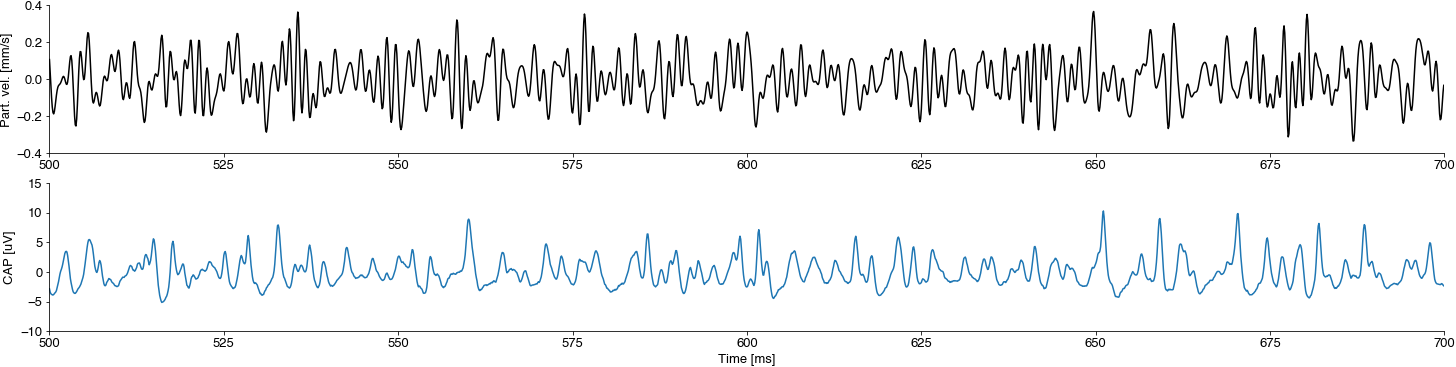

In [4]:
t0 = 5000
t1 = 7000
T = np.arange(t0, t1) / fs * 1000

plt.gcf().set_size_inches(25, 6)
plt.subplot(211)
plt.plot(T, x[t0:t1], c='k')
plt.ylabel('Part. vel. [mm/s]')

plt.subplot(212)
plt.plot(T, y[t0:t1])
plt.ylabel('CAP [uV]')
plt.xlabel('Time [ms]')

In [5]:
win_len = int(10 * fs / 1000)  # ms
X, y = pre.time_delay_embedding(x, y, window_size=win_len)

steps = [('quad_exp', PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)),
         ('ridge', BayesianRidge(normalize=True))]

with TemporaryDirectory() as tempdir:
    clf = Pipeline(steps, memory=tempdir)
    clf.fit(X, y)
    y_pred, y_pred_std = clf.predict(X, return_std=True)
    print(f'r2={clf.score(X, y):1.2}')
    
bias, linear, quadratic = post.unpack_quadratic_kernel(clf[-1].coef_, win_len,
                                                       quad_as_matrix=True, reverse_time=True)
eig_val, eig_vec = np.linalg.eig(quadratic)

weight_std = np.diag(clf[-1].sigma_)
bias_std, linear_std, quadratic_std = post.unpack_quadratic_kernel(weight_std, win_len,
                                                                   quad_as_matrix=True, reverse_time=True)

r2=0.78


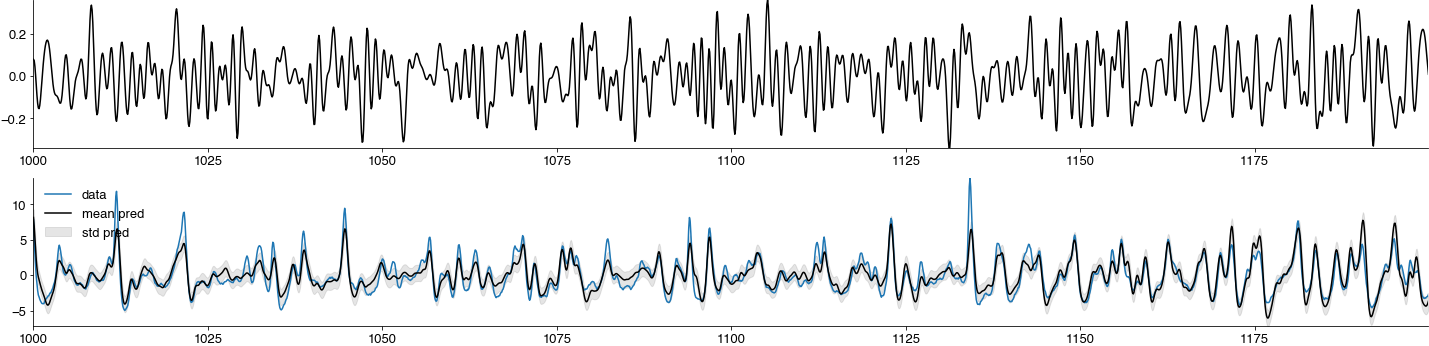

In [6]:
t0 = 10_000
t1 = 12_000
T = np.arange(t0, t1) / fs * 1000  # ms

plt.gcf().set_size_inches(25,6)
plt.subplot(211)
plt.plot(T, x[t0:t1], c='k', label='stimulus')
plt.autoscale(enable=True, axis='both', tight=True)

plt.subplot(212)
plt.plot(T, y[t0:t1], label='data')
plot_mean_and_CI(T, y_pred[t0:t1], y_pred_std[t0:t1], alpha=0.1)
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend()


/Users/clemens10/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


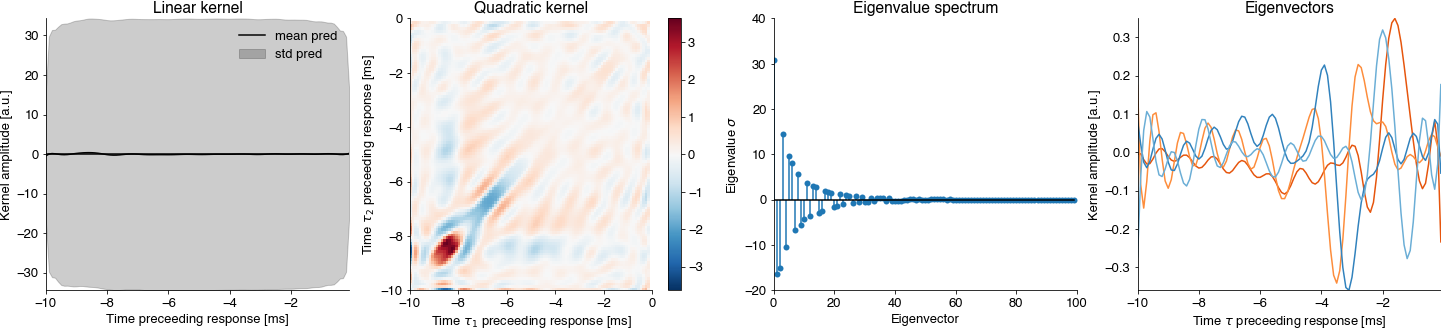

In [19]:
tau = np.arange(-win_len, 0) / fs * 1000

plt.gcf().set_size_inches(25,5)
plt.subplot(141)

plot_mean_and_CI(tau, linear, linear_std)
plt.xlabel('Time preceeding response [ms]')
plt.ylabel('Kernel amplitude [a.u.]')
plt.title('Linear kernel')
plt.axhline(0, c='k')
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend()

plt.subplot(142)
plt.pcolor(tau, tau, quadratic, cmap='RdBu_r')
plt.clim(-np.max(np.abs(quadratic)), np.max(np.abs(quadratic)))
plt.xlabel(r'Time $\tau_1$ preceeding response [ms]')
plt.ylabel(r'Time $\tau_2$ preceeding response [ms]')
plt.title('Quadratic kernel')
plt.colorbar()

plt.subplot(143)
plt.stem(eig_val, basefmt='k', use_line_collection=True)
plt.xlabel('Eigenvector')
plt.ylabel(r'Eigenvalue $\sigma$')
plt.title('Eigenvalue spectrum')

plt.subplot(144)
[plt.plot(tau, filt[::-1], c=col) for filt, col in zip(eig_vec[:,:4].T, cols)]
plt.xlabel(r'Time $\tau$ preceeding response [ms]')
plt.ylabel('Kernel amplitude [a.u.]')
plt.title('Eigenvectors')
plt.autoscale(enable=True, axis='both', tight=True)